# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_sharing_and_log"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.000287,0.005611,-0.051102,0.959245,0.520377,random.pheno988
1,LV2,0.004379,0.003806,1.150497,0.249982,0.124991,random.pheno988
2,LV3,-0.010486,0.008155,-1.285906,0.198522,0.900739,random.pheno988
3,LV4,-0.008629,0.009072,-0.951166,0.341556,0.829222,random.pheno988
4,LV5,0.001906,0.012116,0.157329,0.874991,0.437495,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.049896656534954405

# QQ-plot

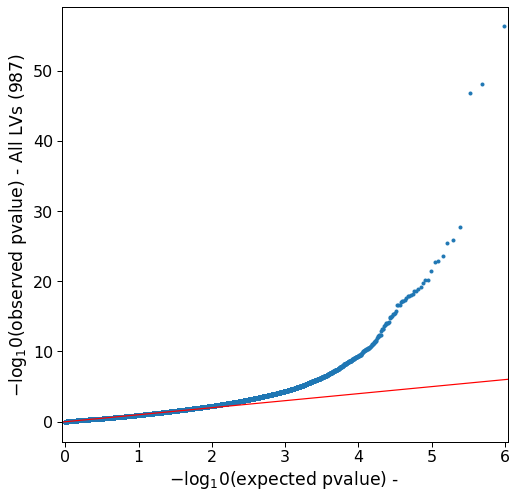

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.001,0.006,0.013
1,LV10,0.019,0.067,0.127
2,LV100,0.010,0.031,0.053
3,LV101,0.025,0.103,0.168
4,LV102,0.010,0.053,0.095


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.014876,0.049897,0.089662
std,0.019417,0.038797,0.055730
min,0.000000,0.000000,0.000000
25%,0.003000,0.021000,0.049000
50%,0.012000,0.050000,0.095000
75%,0.019000,0.068000,0.122000
max,0.239000,0.348000,0.408000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(49, 4)

,lv,1,5,10
486,LV537,0.015,0.049,0.087
919,LV927,0.009,0.049,0.098
451,LV505,0.014,0.049,0.092
62,LV155,0.010,0.049,0.089
143,LV228,0.014,0.049,0.095
851,LV866,0.017,0.049,0.084
779,LV800,0.008,0.049,0.102
442,LV498,0.017,0.049,0.091
718,LV746,0.006,0.049,0.099
432,LV489,0.007,0.049,0.101


,lv,1,5,10
240,LV315,0.010,0.050,0.108
942,LV948,0.013,0.050,0.118
252,LV326,0.014,0.050,0.096
323,LV390,0.013,0.050,0.097
245,LV32,0.015,0.050,0.106
628,LV665,0.006,0.051,0.104
13,LV110,0.016,0.051,0.096
37,LV132,0.015,0.051,0.083
892,LV902,0.010,0.051,0.101
168,LV250,0.009,0.051,0.109


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(332, 4)

,lv,1,5,10
436,LV492,0.067,0.152,0.223
129,LV215,0.065,0.152,0.221
255,LV329,0.107,0.166,0.200
153,LV237,0.081,0.167,0.226
289,LV36,0.104,0.174,0.224
349,LV413,0.102,0.181,0.230
549,LV594,0.111,0.186,0.243
24,LV120,0.094,0.189,0.259
466,LV519,0.113,0.192,0.257
401,LV460,0.102,0.195,0.246


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010450,0.008593,1.216076,0.224001,0.112000,random.pheno988
1031,LV45,0.002799,0.008648,0.323674,0.746195,0.373098,random.pheno589
2018,LV45,0.001009,0.008574,0.117648,0.906350,0.453175,random.pheno385
3005,LV45,0.003886,0.008678,0.447746,0.654352,0.327176,random.pheno5
3992,LV45,-0.018135,0.008597,-2.109604,0.034931,0.982535,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.105

In [33]:
show_prop(results, 0.10)

0.154

In [34]:
show_prop(results, 0.15)

0.2

In [35]:
show_prop(results, 0.20)

0.237

### QQplot

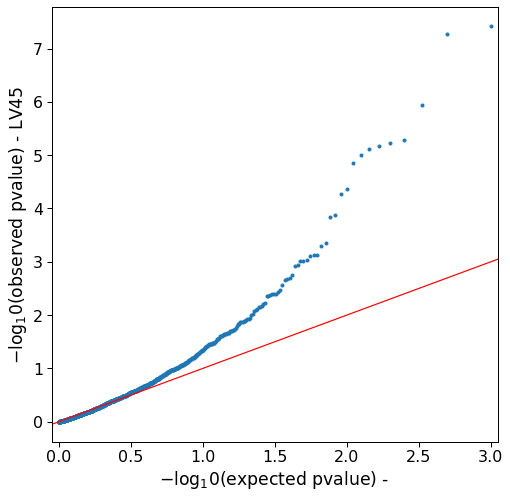

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.015758,0.010668,1.477175,0.139678,0.069839,random.pheno988
1220,LV234,0.003506,0.010736,0.326539,0.744027,0.372014,random.pheno589
2207,LV234,-0.004472,0.010644,-0.420137,0.674399,0.662800,random.pheno385
3194,LV234,0.005007,0.010774,0.464764,0.642116,0.321058,random.pheno5
4181,LV234,0.003782,0.010676,0.354266,0.723151,0.361575,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.015

In [43]:
show_prop(results, 0.05)

0.058

In [44]:
show_prop(results, 0.10)

0.103

In [45]:
show_prop(results, 0.15)

0.154

In [46]:
show_prop(results, 0.20)

0.202

### QQplot

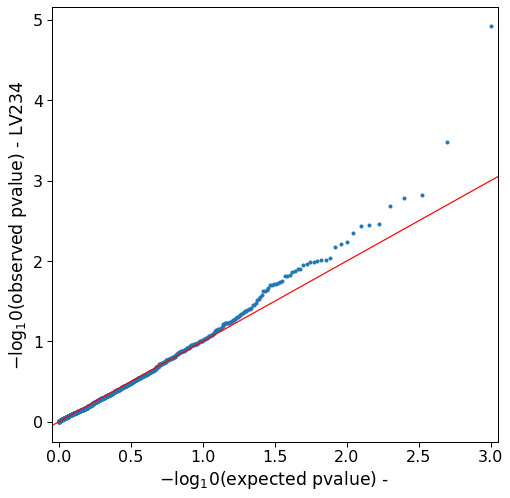

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.002259,0.010899,0.207230,0.835837,0.417919,random.pheno988
1833,LV847,-0.002985,0.010968,-0.272148,0.785517,0.607241,random.pheno589
2820,LV847,-0.012851,0.010873,-1.181902,0.237288,0.881356,random.pheno385
3807,LV847,-0.003765,0.011006,-0.342064,0.732314,0.633843,random.pheno5
4794,LV847,0.006977,0.010906,0.639770,0.522345,0.261172,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.008

In [54]:
show_prop(results, 0.05)

0.056

In [55]:
show_prop(results, 0.10)

0.096

In [56]:
show_prop(results, 0.15)

0.139

In [57]:
show_prop(results, 0.20)

0.178

### QQplot

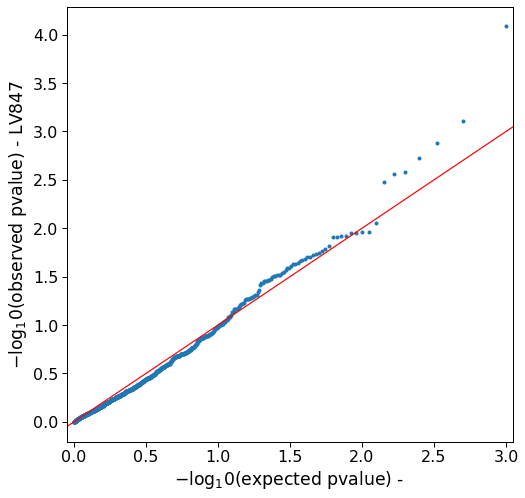

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022630,0.008880,-2.548392,0.010845,0.994577,random.pheno988
1096,LV110,-0.012942,0.008939,-1.447865,0.147703,0.926148,random.pheno589
2083,LV110,-0.008555,0.008863,-0.965225,0.334468,0.832766,random.pheno385
3070,LV110,-0.008357,0.008971,-0.931568,0.351595,0.824203,random.pheno5
4057,LV110,0.008828,0.008889,0.993040,0.320728,0.160364,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.016

In [65]:
show_prop(results, 0.05)

0.051

In [66]:
show_prop(results, 0.10)

0.096

In [67]:
show_prop(results, 0.15)

0.142

In [68]:
show_prop(results, 0.20)

0.19

### QQplot

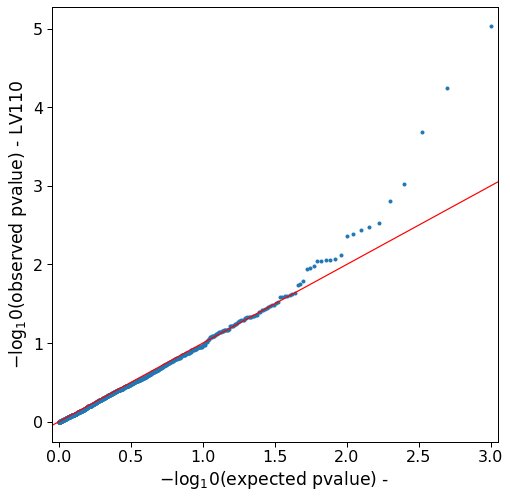

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014879,0.010262,1.449875,0.147142,0.073571,random.pheno988
1755,LV769,-0.006950,0.010328,-0.672962,0.500995,0.749502,random.pheno589
2742,LV769,-0.010758,0.010239,-1.050653,0.293458,0.853271,random.pheno385
3729,LV769,-0.014269,0.010363,-1.376866,0.168601,0.915699,random.pheno5
4716,LV769,-0.018870,0.010268,-1.837772,0.066142,0.966929,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.056

In [76]:
show_prop(results, 0.05)

0.146

In [77]:
show_prop(results, 0.10)

0.211

In [78]:
show_prop(results, 0.15)

0.258

In [79]:
show_prop(results, 0.20)

0.319

### QQplot

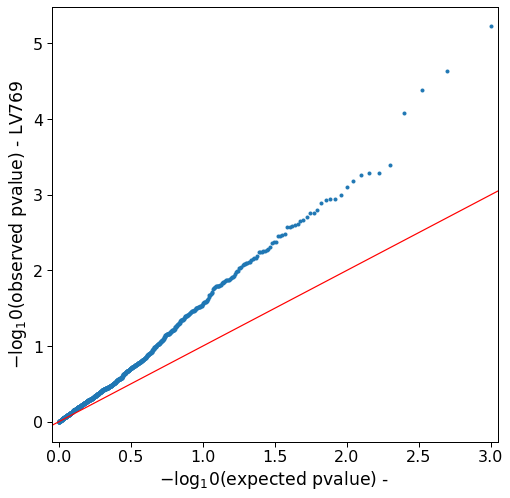

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.008101,0.012941,0.625973,0.531355,0.265677,random.pheno988
1786,LV800,-0.013887,0.013021,-1.066562,0.286210,0.856895,random.pheno589
2773,LV800,-0.002398,0.012911,-0.185740,0.852655,0.573673,random.pheno385
3760,LV800,-0.016588,0.013066,-1.269523,0.204301,0.897850,random.pheno5
4747,LV800,-0.016024,0.012948,-1.237543,0.215931,0.892035,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.008

In [87]:
show_prop(results, 0.05)

0.049

In [88]:
show_prop(results, 0.10)

0.102

In [89]:
show_prop(results, 0.15)

0.143

In [90]:
show_prop(results, 0.20)

0.199

### QQplot

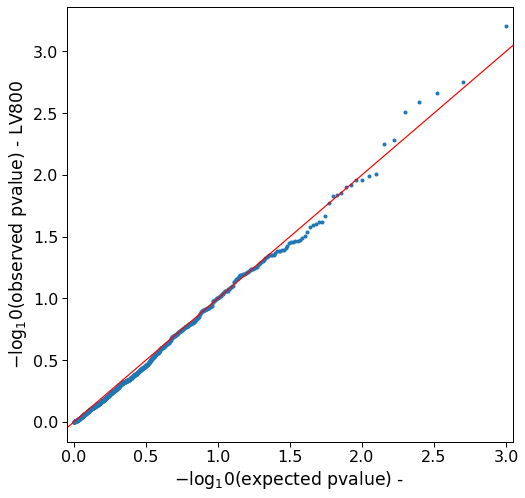

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
486,LV537,0.015,0.049,0.087
919,LV927,0.009,0.049,0.098
451,LV505,0.014,0.049,0.092
62,LV155,0.010,0.049,0.089
143,LV228,0.014,0.049,0.095
851,LV866,0.017,0.049,0.084
779,LV800,0.008,0.049,0.102
442,LV498,0.017,0.049,0.091
718,LV746,0.006,0.049,0.099
432,LV489,0.007,0.049,0.101


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.000716,0.007046,0.101616,0.919064,0.459532,random.pheno988
1398,LV412,-0.004501,0.007090,-0.634873,0.525534,0.737233,random.pheno589
2385,LV412,0.002896,0.007030,0.411954,0.680387,0.340193,random.pheno385
3372,LV412,-0.002615,0.007115,-0.367521,0.713243,0.643379,random.pheno5
4359,LV412,0.008617,0.007050,1.222342,0.221623,0.110812,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.004

In [100]:
show_prop(results, 0.05)

0.015

In [101]:
show_prop(results, 0.10)

0.049

In [102]:
show_prop(results, 0.15)

0.09

In [103]:
show_prop(results, 0.20)

0.131

### QQplot

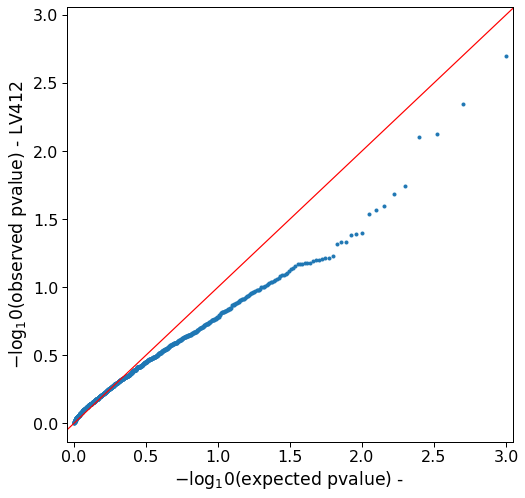

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.025864,0.011048,-2.341038,0.019261,0.990370,random.pheno988
1043,LV57,0.000717,0.011122,0.064438,0.948623,0.474312,random.pheno589
2030,LV57,0.022914,0.011023,2.078667,0.037687,0.018844,random.pheno385
3017,LV57,-0.004457,0.011161,-0.399295,0.689689,0.655155,random.pheno5
4004,LV57,0.010387,0.011059,0.939182,0.347672,0.173836,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.007

In [111]:
show_prop(results, 0.05)

0.053

In [112]:
show_prop(results, 0.10)

0.113

In [113]:
show_prop(results, 0.15)

0.163

In [114]:
show_prop(results, 0.20)

0.205

### QQplot

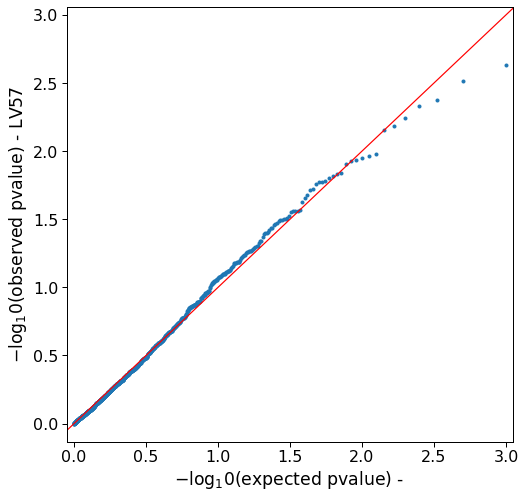

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007042,0.010813,-0.651227,0.514923,0.742539,random.pheno988
1633,LV647,0.008288,0.010880,0.761761,0.446231,0.223115,random.pheno589
2620,LV647,0.013555,0.010787,1.256636,0.208931,0.104465,random.pheno385
3607,LV647,-0.000638,0.010919,-0.058433,0.953405,0.523297,random.pheno5
4594,LV647,0.017238,0.010818,1.593455,0.111107,0.055554,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.021

In [122]:
show_prop(results, 0.05)

0.069

In [123]:
show_prop(results, 0.10)

0.112

In [124]:
show_prop(results, 0.15)

0.155

In [125]:
show_prop(results, 0.20)

0.203

### QQplot

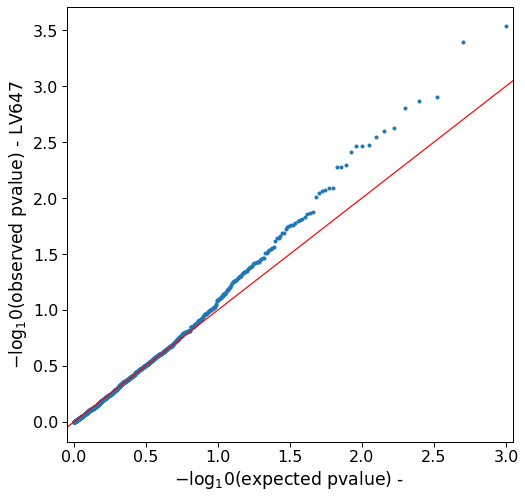

In [126]:
qqplot_unif(results)